In [1]:
import topos
import topos.bp as bp
import fp

import torch
import matplotlib.pyplot as plt

plt.set_cmap('viridis')
#plt.style.use('dark_background')
imgdir = '/home/oli/math/maxEnt/Figures'


<Figure size 640x480 with 0 Axes>

In [2]:
from topos.bp import IsingNetwork as Ising
N = Ising.lattice(2, 3)

In [3]:
""" Singular elements """

def radial_conservative(field=1, beta=None, gamma=None):
    """ Span of (U, V) with V = codiff(phi) """
    if beta is None:  beta  = torch.linspace(.4, 1.6, 101)
    if gamma is None: gamma = .5 * torch.linspace(-2, 1.3, 101)
    #--- singular beliefs
    log_third = float(torch.log(torch.ones(1) / 3))
    p_sg = N.lift_interaction([field, -log_third])
    #--- singular flux
    vec = N.node_eigvecs(p_sg).data[:2] 
    phi = vec.repeat(len(N.grades[1]))
    phi = N[1].field(phi)
    #--- coordinate plane
    U_sg = N._ln(p_sg)
    V_sg = N.zeta(N.codiff(phi))
    U = beta[:,None] * U_sg.data
    V = gamma[:,None] * V_sg.data
    return N[0].field(U + V[:,None,:])

/home/oli/fp/fp/instances/tens.py:260: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  data = torch.sparse.mm(f.data, g.data)


torch.Size([4, 501, 501])


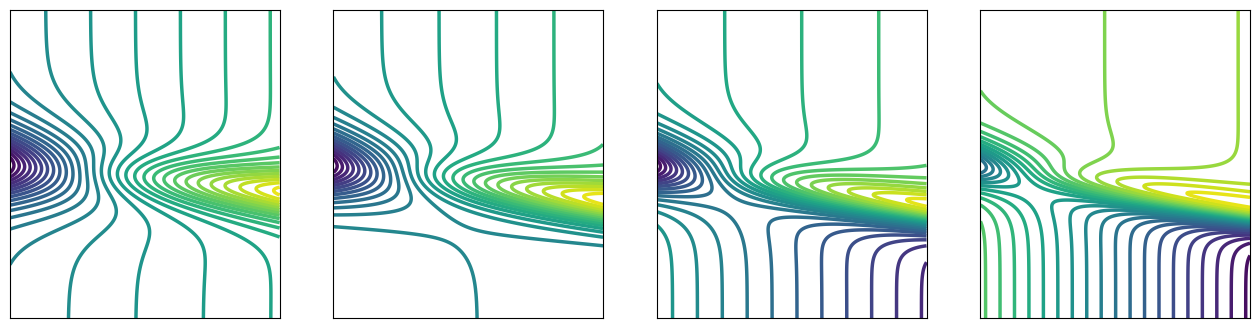

In [4]:
""" Free energy landscape accross singularity """
from topos.io import plot_contours

field_UV = [.4, .6, .8, 1.]
beta = torch.linspace(.1, 3, 501)
gamma = torch.linspace(-1.5, 1.5, 501)
UV = [radial_conservative(fi, beta, gamma) for fi in field_UV]
UV = N[0].Field().batch(UV)

F_UV = N.freeBethe(1.)(UV).data
fig = plot_contours(F_UV, levels=30, lw=2.5, size=(16, 4))

#fig.savefig(f'{imgdir}/ising_contours_2.svg')

[]

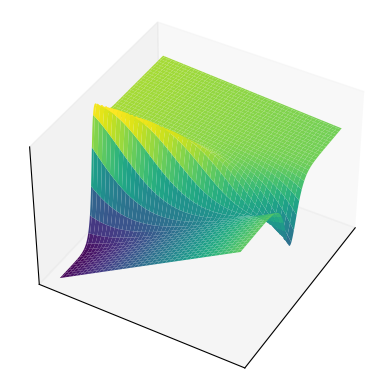

In [5]:
fig, ax = plt.subplots(subplot_kw = {"projection":"3d"})
ax.plot_surface(beta[:,None], gamma[None,:], F_UV[-1], cmap='viridis')
ax.view_init(40, 210)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
